# Yelp Review Sentiment Analysis Demo

In [1]:
import os
import re
import json
import numpy as np
from num2words import num2words
import matplotlib.pyplot as plt

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, Conv1D, MaxPooling1D
from keras.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
def load_data(filepath, max_samples=None):
    """
    Takes a .json filepath with yelp reviews and appends the sentiment
    (1 meaning positive for 4-5 star ratings and 0 meaning negative for 1-3 star ratings)
    to the sentiment list and the text to the text list.

    Function will load same number of positive and negative reviews

    Return the text list and sentiments numpy array as a tuple
    """
    stars_to_sentiment = {1: 0, 2: 0, 3: 0, 4: 1, 5: 1}
    sentiments = []
    text = []

    # Open file and read lines
    with open(filepath) as f:
        lines = f.readlines()

        # If given max_samples, set a limit for each review type and count to make sure they're equal
        if max_samples is not None:
            limit = max_samples//2
            counts = {0: 0, 1: 0}

        # Loop through every sample
        for line in lines:
            data = json.loads(line)
            sentiment = stars_to_sentiment[data["stars"]]

            # Add sentiments and text
            if counts[sentiment] < limit:
                text.append(data['text'])
                sentiments.append(sentiment)
                counts[sentiment] += 1

            # Break out of loop if positive and negative reviews hit limit
            if counts[0] == limit and counts[1] == limit:
                break

        return text, sentiments

In [3]:
def clean_text(text, stop_list=[]):
    """
    Takes a list of strings and "cleans" the text.

    We define cleaning as...

    replacing any dashes with spaces (ie: "long-term" -> "long term")
    removing punctuation/special characters (ie: "great!" -> "great",   "wish," -> "wish")
    changing all words to lowercase (ie: "Great" -> "great",   "FANTASTIC," -> "fantastic")
    removing words that appear on stop list if one is provided
    turn reviews into lists of words

    Returns a list of strings containing the words used in each review.
    """
    clean = []


    # Loop through every review
    for review in text:
        cleaned_review = ""

        # Loop through every word in the review splitting along spaces, dashes, or periods
        for word in re.split(r'[.\s-]+', review):
            # If word is number, change to word
            if word.isdecimal():
                word = num2words(word)

            # Remove special characters from word and make lowercase
            word = re.sub('[^A-Za-z0-9]+', '', word).lower()

            # Add any words to cleaned_review
            if word != "" and word not in stop_list:
                cleaned_review = cleaned_review + word + " "

        # Add cleaned review to clean
        clean.append(cleaned_review[:-1])

    return clean

In [4]:
def preprocess(datapath, max_samples, stoplist=[]):
    """
    Do all the preprocessing and returns text vectors (either embedded or not) and sentiments as a tuple.
    Also returns tokenizer for predicting later.

    datapath is the path the the yelp reviews dataset
    max_samples are the number of samples we'll take from the dataset of over 8 million reviews
    stoplist is a list of words to remove from the data
    """
    # Load data
    text, sentiments = load_data(filepath=datapath, max_samples=max_samples)
    print("Data loaded.")

    # Clean text
    text = clean_text(text, stoplist)
    print("Text Cleaned.")

    # Tokenize text for keras embedding
    tokenizer = Tokenizer(num_words=25000)
    tokenizer.fit_on_texts(text)
    sequences = tokenizer.texts_to_sequences(text)
    vectors = pad_sequences(sequences, maxlen=350)
    print("Text Tokenized.")


    print("Preprocessing Complete.")
    return vectors, sentiments, tokenizer

In [5]:
def train_model(vectors, sentiments, epochs, conv=False):
    """
    Trains model given transformed yelp review vectors and sentiments list

    If conv flag is set to True, model will add a 1D convolutional layer to embedding

    Returns model and history
    """
    # Split into training and test sets
    print("Spliting Data.")
    X_train, X_test, y_train, y_test = train_test_split(vectors, sentiments, test_size=0.2)

    # Initiate model
    print("Building Model.")
    model = Sequential()

    # Add embedding layer
    model.add(Embedding(25000, 150, input_length=350))

    # Use 1D convolutional layer if specified
    if conv:
        model.add(Dropout(0.2))
        model.add(Conv1D(75, 5, activation='relu'))
        model.add(MaxPooling1D(pool_size=4))

    # Use LSTM with 150 units, dropout and recurrent dropout of 0.2
    model.add(LSTM(150, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(1, activation='sigmoid'))

    # Compile model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Fit model
    history = model.fit(X_train, np.array(y_train), validation_data=(X_test, np.array(y_test)), epochs=epochs)

    return model, history

In [6]:
def create_accuracy_plot(history):
    """
    Takes model history and plots training and validation accuracy.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['accuracy'], '-o', label="Training Accuracy")
    plt.plot(history.history['val_accuracy'], '-o', label="Validation Accuracy")
    plt.title("Accuracy of Yelp Review Sentiment using LSTM")
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')
    plt.show()

In [7]:
def predict_sentiment(model, new_review_text, tokenizer):
    """
    Interactive predictive function that takes a model and predicts sentiment of user's review
    new_review_text is a list of strings or a string
    """
    if isinstance(new_review_text, str):
        new_review_text = list(new_review_text)
    
    sequences = tokenizer.texts_to_sequences(new_review_text)
    vectors = pad_sequences(sequences, maxlen=350)

    for i in range(len(new_review_text)):
        prediction = float(model.predict(vectors)[i][0])
        print(f"Review: {new_review_text[i]}")

        if prediction > 0.5:
            print(f"There is a {round(prediction*100, 4)}% this review is positive.\n")
        else:
            print(f"There is a {round((1-prediction)*100, 4)}% this review is negative.\n")


In [8]:
# Path to yelp review
path = "./YelpReviews/data/yelp_academic_dataset_review.json"

# Adjust the parameters below as you like

# Number of samples to select
max_samples = 10000

# Words on the stoplist will be removed from training data reviews
stoplist = ['the', 'and', 'a', 'i', 'to', 'of', 'was', 'it', 'is', 
            'for', 'in', 'my', 'that', 'with', 'they', 'on', 'we', 
            'this', 'you', 'not', 'have', 'had', 'so', 'are', 'at', 
            'be', 'were', 'there', 'as', 'me', 'its', 'if', 'their', 
            'here', 'just', 'one', 'time', 'when', 'get', 'or', 'our', 
            'about', 'will', 'also', 'an', 'would', 'what', 'which', 
            'them', 'can', 'been', 'your', 'she', 'he', 'by', 'got', 
            'dont', 'ive', 'too', 'im', 'do', 'because', 'us', 'has', 
            'made', 'come', 'did', 'went', 'who', 'make', 'way', 'came', 
            'going', 'then', 'her', 'how', 'being', 'while', 'youre', 'am']

# Conv flag to determine if model uses 1D convolutional and max pooling layer
conv = False

# Reviews for the model to predict
new_reviews = ["I liked the food. It was delicious.", "I hate this place. The food was awful."]

# Number of epochs
epochs = 3

In [9]:
# Preprocess data
X, y, tokenizer = preprocess(path, max_samples=max_samples, stoplist=stoplist)

Data loaded.
Text Cleaned.
Text Tokenized.
Preprocessing Complete.


In [10]:
# Train model
model, history = train_model(X, y, epochs, conv=conv)

Spliting Data.
Building Model.
Epoch 1/3
228/228 [==============================] - 109s 476ms/step - loss: 0.4824 - accuracy: 0.7778 - val_loss: 0.3854 - val_accuracy: 0.8336
Epoch 2/3
228/228 [==============================] - 114s 502ms/step - loss: 0.2386 - accuracy: 0.9099 - val_loss: 0.3913 - val_accuracy: 0.8364
Epoch 3/3
228/228 [==============================] - 109s 477ms/step - loss: 0.1217 - accuracy: 0.9587 - val_loss: 0.4979 - val_accuracy: 0.8331


In [11]:
# View Model Summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 350, 150)          3750000   
_________________________________________________________________
lstm (LSTM)                  (None, 150)               180600    
_________________________________________________________________
dense (Dense)                (None, 1)                 151       
Total params: 3,930,751
Trainable params: 3,930,751
Non-trainable params: 0
_________________________________________________________________


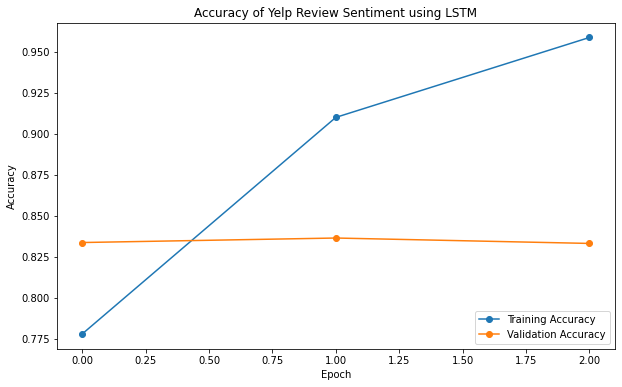

In [12]:
# Plot accuracy
create_accuracy_plot(history)

In [13]:
# Predict sentiment of user generated review
predict_sentiment(model, new_reviews, tokenizer)

Review: I liked the food. It was delicious.
There is a 93.5176% this review is positive.

Review: I hate this place. The food was awful.
There is a 93.6097% this review is negative.

